In [7]:
import ecephys_analyses as ea
from ecephys.sglx_utils import load_timeseries
from pyedflib import highlevel as edf
import numpy as np
from scipy.interpolate import interp1d
import xarray as xr

In [2]:
subject = "Allan"
experiment = "ketamine"
condition = "all"

In [3]:
bin_paths = ea.get_sglx_style_datapaths(subject, experiment, condition, ext="lf.bin")
emg_paths = ea.get_sglx_style_datapaths(subject, experiment, condition, ext="emg.nc")
edf_paths = ea.get_sglx_style_datapaths(subject, experiment, condition, ext="edf")

In [4]:
bin_path = bin_paths[0]
emg_path = emg_paths[0]
edf_path = edf_paths[0]
chans = [189, 361, 50]
target_fs = 100.0

In [5]:
sig = load_timeseries(bin_path, chans=chans)

nChan: 385, nFileSamp: 17610153


In [8]:
emg = xr.open_dataarray(emg_path)

In [10]:
def resample(sig, target_fs):
    f = interp1d(sig.time, sig.T, kind='cubic')
    new_times = np.arange(sig.time.min(), sig.time.max(), 1/target_fs)
    new_data = f(new_times)
    return (new_times, new_data)

In [15]:
sig_time_rs, sig_data_rs = resample(sig, target_fs)

In [16]:
emg_time_rs, emg_data_rs = resample(emg, target_fs)

In [33]:
signals = np.vstack([sig_data_rs, emg_data_rs])
signal_labels = [f"LF{ch}" for ch in chans] + ["dEMG"]

In [34]:
signal_headers = edf.make_signal_headers(signal_labels, dimension=sig.units, sample_rate=target_fs, physical_min=signals.min(), physical_max=signals.max())
edf.write_edf(str(edf_path), signals, signal_headers)

/home/gfindlay/miniconda3/envs/ecephys/lib/python3.7/site-packages/pyedflib/highlevel.py:487: UserWarning: signals are in Fortran order. Will automatically transfer to C order for compatibility with edflib.
  warnings.warn('signals are in Fortran order. Will automatically ' \


True

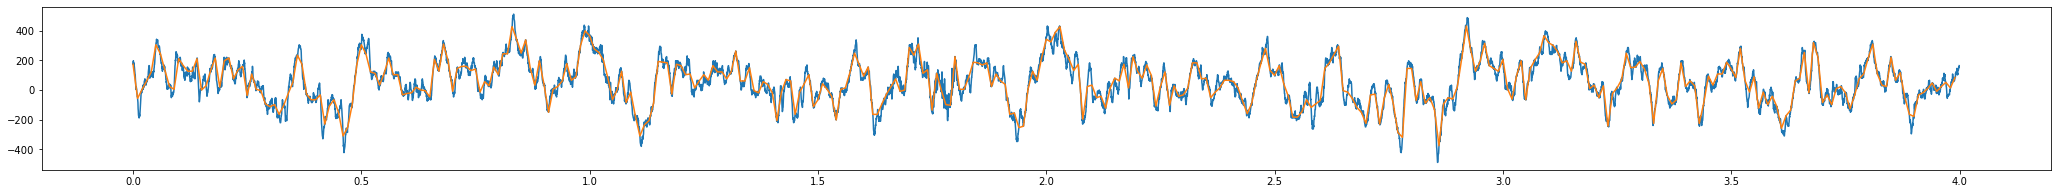

In [19]:
import matplotlib.pyplot as plt

iCh = 0
n_seconds = 4

fig, ax = plt.subplots(figsize=(36, 3))
ax.plot(sig.time.values[:int(n_seconds*sig.fs)], sig.T.values[iCh, :int(n_seconds*sig.fs)])
ax.plot(sig_time_rs[:int(n_seconds*target_fs)], sig_data_rs[iCh, :int(n_seconds*target_fs)])

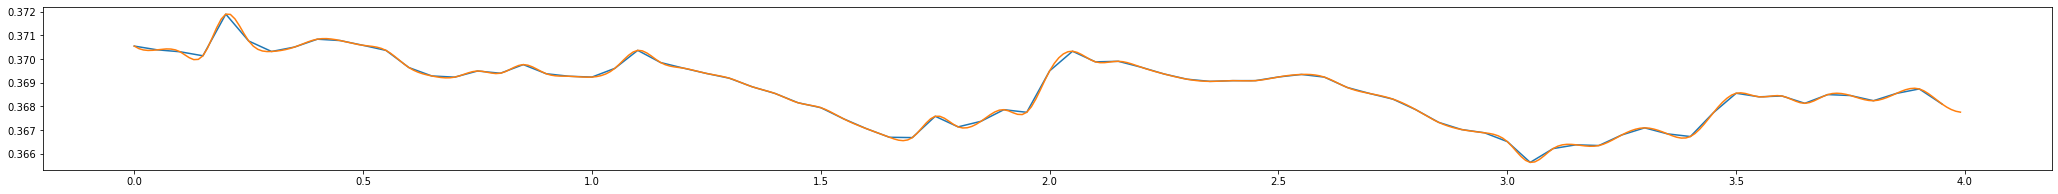

In [20]:
n_seconds = 4

fig, ax = plt.subplots(figsize=(36, 3))
ax.plot(emg.time.values[:int(n_seconds*emg.target_sf)], emg.values[:int(n_seconds*emg.target_sf)])
ax.plot(emg_time_rs[:int(n_seconds*target_fs)], emg_data_rs[:int(n_seconds*target_fs)])